This is the second attempt, gunna do yolo for object detection and gunna use unet for semantic segmentaion

In [ ]:
from google.colab import drive
import os

# Google Colab Patch
use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    # ----------------------------------------
    dir = "/content/drive/MyDrive/Cmput_328/assignment4"    # TODO: MODIFY THIS TO INDICATE THE PARENT FOLDER OF YOUR vit_model.py file
    # ----------------------------------------
    sys.path.append(dir)
from A4_utils import *

Mounted at /content/drive


laod in dataset

In [ ]:
import torch
from torch.utils.data.dataset import Dataset  # For custom data-sets
from torchvision import transforms
import torchvision
from skimage.io import imread
from PIL import Image
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

CLASSES= [
    '__background__', '0'
    '1', '2', '3',
    '4', '5', '6',
    '7', '8', '9'
]

Num_classes = 11

data_path = '/content/drive/MyDrive/Cmput_328/assignment4/mnistdd_rgb_train_valid/'

# training
train_image_path = data_path + 'train_X.npy'
train_label_path = data_path + 'train_Y.npy'
train_bboxes_path = data_path + 'train_bboxes.npy'
train_seg_path = data_path + 'train_seg.npy'

# validation
valid_image_path= data_path + 'valid_X.npy'
valid_label_path= data_path +'valid_Y.npy'
valid_bboxes_path = data_path +'valid_bboxes.npy'
valid_seg_path = data_path +'valid_seg.npy'


class CustomDataset(Dataset):
    def __init__(self, image_paths, label_paths, masks_paths, train=True):   # initial logic happens like transform
        self.images = np.load(image_paths)
        self.label =  np.load(label_paths)
        self.mask = np.load(masks_paths)
        self.transforms_image = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    def __getitem__(self, index):

         # Retrieve and preprocess a sample
        image = self.images[index].reshape(64, 64, 3)
        image = np.array(image, dtype=np.float32)
        image = image /255
        label = self.label[index]
        mask = self.mask[index].reshape(64, 64)

        image = self.transforms_image(image)
        mask = torch.from_numpy(mask).type(torch.LongTensor)
        return image, mask

    def __len__(self):  # return count of sample we have
        return len(self.images)

Define the unet model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = model(x)
            preds = torch.argmax(preds, dim=1)
            preds = preds.float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def train_function(data, model, optimizer, loss_fn, device):
    print('Entering into train function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data):
        X, y = batch
        X, y = X.to(device), y.to(device)
        preds = model(X)

        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

check to see some smaples

In [ ]:
train_dataset = CustomDataset(train_image_path, train_label_path, train_seg_path, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

valid_dataset = CustomDataset(valid_image_path, valid_label_path, valid_seg_path, train=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

images shape torch.Size([16, 3, 64, 64])
segmentation_masks shape torch.Size([16, 64, 64])


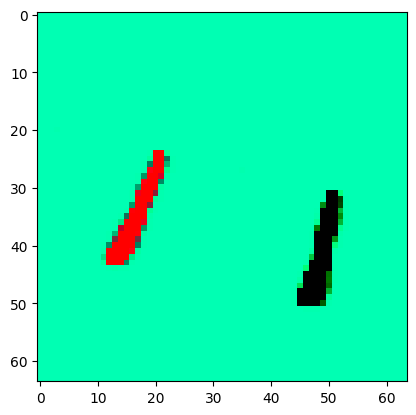

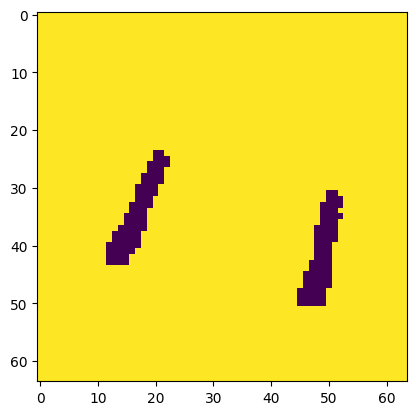

In [ ]:
import matplotlib.pyplot as plt

dataiter = enumerate(train_loader)
batch_idx, (images, target) = next(dataiter)

print(f"images shape {images.shape}")
# print(f"labels shape {target['labels'].shape}")
print(f"segmentation_masks shape {target.shape}")

plt.imshow(images[0].permute(1,2,0).data)
plt.show()
plt.imshow(target[0].data)
plt.show()

# plt.imshow(img_array, cmap='gray')
# plt.show()

In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
PIN_MEMORY = True
MODEL_PATH = 'saved_model.pth'
LOSS_VALS = []

train_dataset = CustomDataset(train_image_path, train_label_path, train_seg_path, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = CustomDataset(valid_image_path, valid_label_path, valid_seg_path, train=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


model = UNET(in_channels=3, out_channels=11).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


check_accuracy(valid_loader, model, device=DEVICE)

#Training the model for every epoch.
for e in range(NUM_EPOCHS):
    print(f'Epoch: {e}')
    loss_val = train_function(train_loader, model, optimizer, loss_fn, DEVICE)
    LOSS_VALS.append(loss_val)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': e,
        'loss_values': LOSS_VALS
    }, MODEL_PATH)
    print("Epoch completed and model successfully saved!")

Got 1757923/20480000 with acc 8.58
Dice score: 9.327704429626465
Epoch: 0
Entering into train function


 38%|███▊      | 1321/3438 [01:32<02:28, 14.30it/s]

A4_main.py